# Hyperspectral data variations

In [4]:
import spectral.io.envi as envi
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

from sklearn.decomposition import PCA
from spectral import principal_components, imshow

The original slides received back in May, in addition to the regular hyperspectral scans, had variations of these scans: false RGB, light scattering corrected, and chemical variation. These were obtained as follows:

  -  False RGB: just bands 39 (red), 24 (green) and 8 (blue).
  -  Light scattering corrected: just the image, normalized by subtracting its mean and dividing by its standard deviation.
  -  Chemical variation: the result of applying PCA to the image, and keeping the first 3 components as RGB channels.
  
Note that the results that will be obtained here may differ with the results in the slides, as those came from another hyperspectral scanner.

## False RGB display

In [133]:
def show_false_rgb(pole_id, rotation_idx):
    paths = os.listdir(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", str(pole_id)))
    paths = [path for path in paths if "float32.hdr" in path]
    paths.sort()
    img = envi.open(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", str(pole_id), paths[rotation_idx])).load()
    
    img = np.take(img, [39, 24, 8], axis=2)
    img = np.where(img > 0.025, 0, img)
    img = np.interp(img, (img.min(), img.max()), (0, 1))
    
    print(np.max(img))
    plt.imshow(img)

1.0


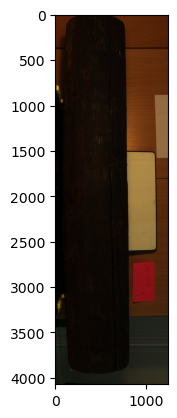

In [134]:
show_false_rgb(0, 0)

In this image, the ALMOST real aspect of the pole can be seen, as the chosen channels are nearly identical to the regular RGB channels. Therefore, an interesting visualization is to see all poles in this fashion, and look for characteristics that might help distinguishing them.

In [1]:
def view_hyperspectral_transformed(transform_func, description):
    fig, axes = plt.subplots(5, 6, figsize=(20,16))
    pole_ids = [0,30,41,6,5]
    pole_status = ['31/37', '17/24', '15/24', '12/24', '11/24']
    specific_status = ['New', 'Rotten', 'Cracks', 'Cracks', 'Rotten']

    for pole_idx, pole_id in enumerate(pole_ids):
        paths = os.listdir(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", str(pole_id)))
        paths = [path for path in paths if "float32.hdr" in path]
        paths.sort()
        for scan_idx in range(len(paths)):
            img = envi.open(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", str(pole_id), paths[scan_idx])).load()
            img = transform_func(img)
            axes[pole_idx, scan_idx].imshow(img)

    fig.suptitle(description)

    [axes[0,i].set_title(f'Image #{i}') for i in range(6)]

    [axes[i,0].set_ylabel(f'Pole {pole}\nStatus: {pole_status[i]}\nCause: {specific_status[i]}', labelpad=60, fontdict={'rotation':0}) for i, pole in enumerate(pole_ids)]
    
    #plt.savefig(f'../Figures/Hyperspectral {description}.png', dpi=1000)

In [12]:
def hyperspectral_to_false_rgb(img):
    img = np.take(img, [39, 24, 8], axis=2)
    img = np.where(img > 0.025, 0, img)
    img = np.log(0.01+img)
    
    img[...,0] = np.interp(img[...,0], (img[...,0].min(), img[...,0].max()), (0, 1))
    img[...,1] = np.interp(img[...,1], (img[...,1].min(), img[...,1].max()), (0, 1))
    img[...,2] = np.interp(img[...,2], (img[...,2].min(), img[...,2].max()), (0, 1))
    
    return img

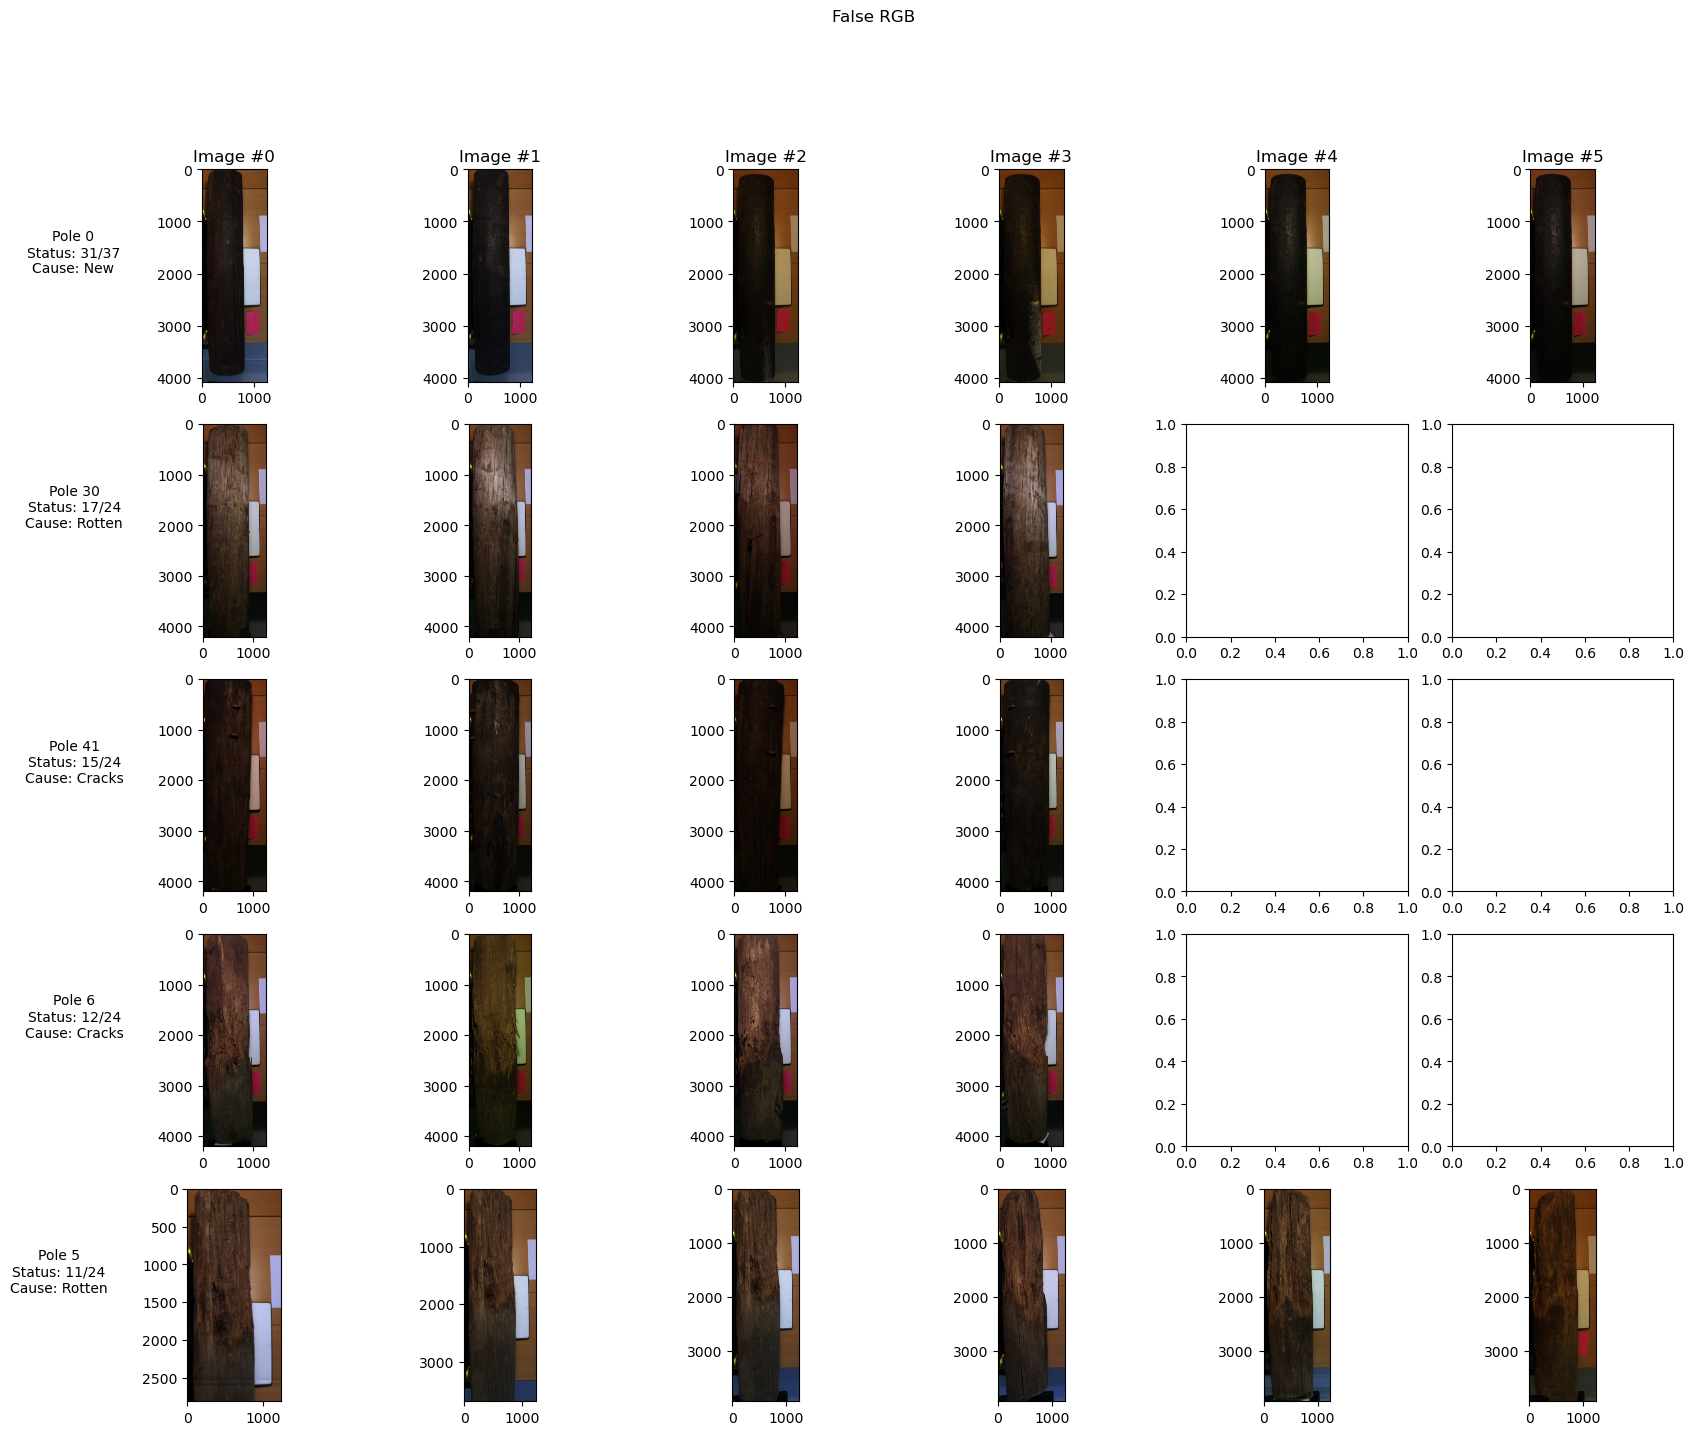

In [13]:
view_hyperspectral_transformed(hyperspectral_to_false_rgb, 'False RGB')

As it can be seen in these figures, there seems to be not much difference with what has already been seen in the RGB images; i.e., worse poles tend to be paler, whereas pole 0, the newest one, is the darkest one. No more analysis will be done for now of the false RGB poles.

## Light scattering corrected

As it was previously said, these are just the regular pole images, but they have been normalized by subtracting their mean and dividing by their standard deviation.

In [5]:
def hyperspectral_to_light_correct(img):
    img = np.where(img > 0.025, 0, img)
    img = (img - np.mean(img, axis=(0,1))) / np.std(img, axis=(0,1))
    img = np.take(img, [39, 24, 8], axis=2)
    
    img[...,0] = np.interp(img[...,0], (img[...,0].min(), img[...,0].max()), (0, 1))
    img[...,1] = np.interp(img[...,1], (img[...,1].min(), img[...,1].max()), (0, 1))
    img[...,2] = np.interp(img[...,2], (img[...,2].min(), img[...,2].max()), (0, 1))
    
    return img

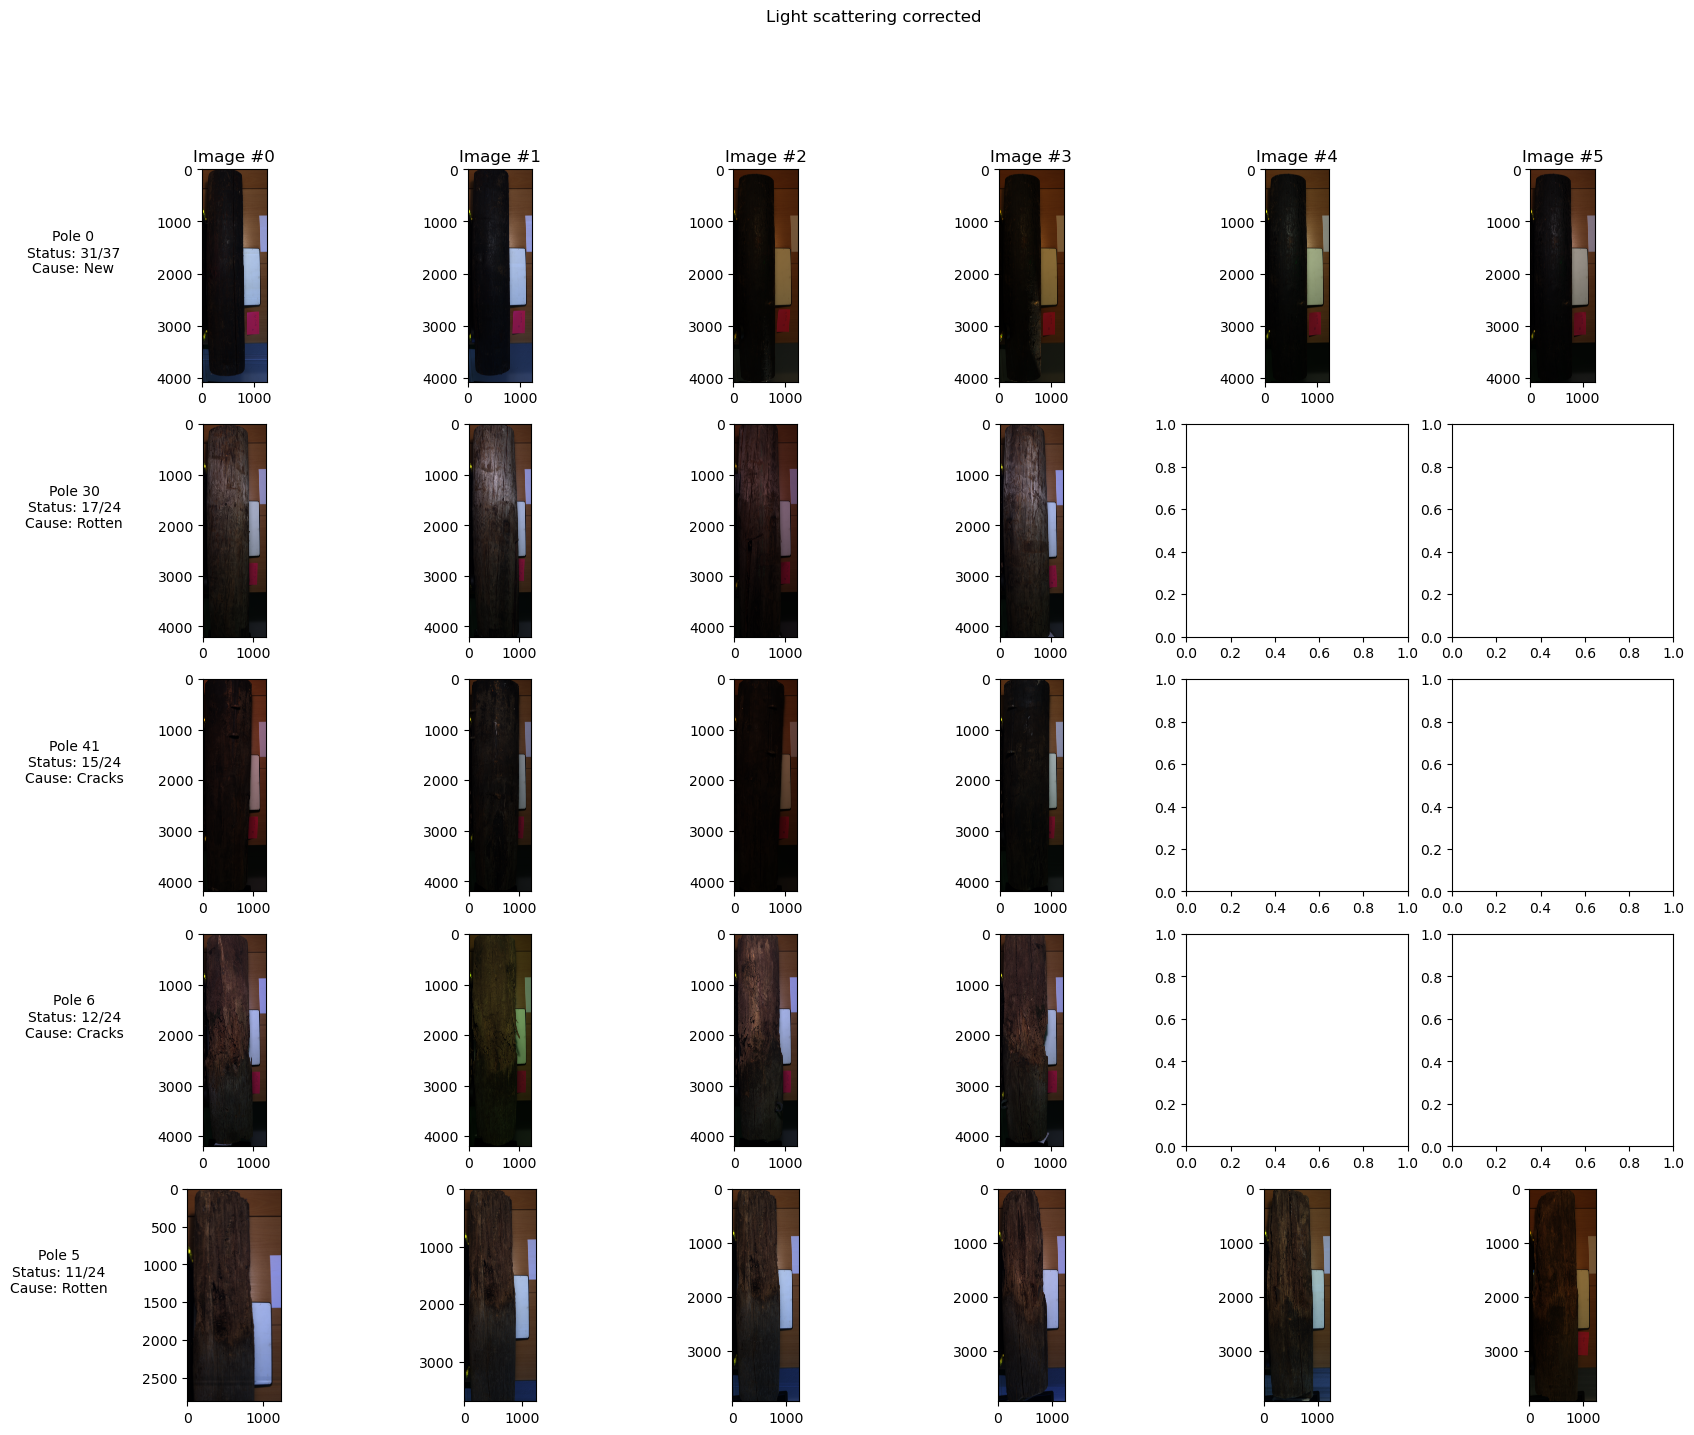

In [6]:
view_hyperspectral_transformed(hyperspectral_to_light_correct, 'Light scattering corrected')

Just as before, there is no much more information that can be infered from these images, as the behaviour is similar to the RGB images. Perhaps the PCA analysis can give more insight.

## Chemical variation

Lastly, this kind of images can be obtained by applying PCA to the hyperspectral scan, and then keeping the three largest components as RGB channels.

In [15]:
def hyperspectral_to_chemical(img):
    img = np.where(img > 0.025, 0, img)
    img = img[150:3900,100:820,:]
    original_dims = img.shape[:-1]
    img = np.reshape(img, (-1, img.shape[-1]))

    pca = PCA(svd_solver='full')
    reduced_img = pca.fit_transform(img)
    reduced_img = np.reshape(reduced_img, (*original_dims, pca.n_components_))
    
    reduced_img[...,0] = np.interp(reduced_img[...,0], (reduced_img[...,0].min(), reduced_img[...,0].max()), (0, 1))
    reduced_img[...,1] = np.interp(reduced_img[...,1], (reduced_img[...,1].min(), reduced_img[...,1].max()), (0, 1))
    reduced_img[...,2] = np.interp(reduced_img[...,2], (reduced_img[...,2].min(), reduced_img[...,2].max()), (0, 1))
    
    return reduced_img[...,:3], pca.components_[:3,...]

def view_hyperspectral_chemical():
    fig, axes = plt.subplots(5, 12, figsize=(40,12))
    pole_ids = [0,30,41,6,5]
    pole_status = ['31/37', '17/24', '15/24', '12/24', '11/24']
    specific_status = ['New', 'Rotten', 'Cracks', 'Cracks', 'Rotten']

    for pole_idx, pole_id in enumerate(pole_ids):
        paths = os.listdir(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", str(pole_id)))
        paths = [path for path in paths if "float32.hdr" in path]
        paths.sort()
        for scan_idx in range(len(paths)):
            img = envi.open(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", str(pole_id), paths[scan_idx])).load()
            wls = np.asarray(img.metadata['wavelength'], float)
            img, components = hyperspectral_to_chemical(img)
            axes[pole_idx, scan_idx*2].imshow(img)
            axes[pole_idx, scan_idx*2 + 1].plot(range(len(components[0])), components[0], color='red', label='PC0')
            axes[pole_idx, scan_idx*2 + 1].plot(range(len(components[1])), components[1], color='green', label='PC1')
            axes[pole_idx, scan_idx*2 + 1].plot(range(len(components[2])), components[2], color='blue', label='PC2')
            axes[pole_idx, scan_idx*2 + 1].set_ylim([-1,1])
            axes[pole_idx, scan_idx*2 + 1].set_xticks(range(0, len(wls), 40), [f'{wls[idx]:.0f}nm' for idx in range(0, len(wls), 40)])

    fig.suptitle('Hyperspectral chemical variation and PCA')

    [axes[0,i * 2].set_title(f'Image #{i}') for i in range(6)]

    [axes[i,0].set_ylabel(f'Pole {pole}\nStatus: {pole_status[i]}\nCause: {specific_status[i]}', labelpad=60, fontdict={'rotation':0}) for i, pole in enumerate(pole_ids)]
    
    plt.savefig(f'../Figures/Hyperspectral chemical PCA.png', dpi=500)

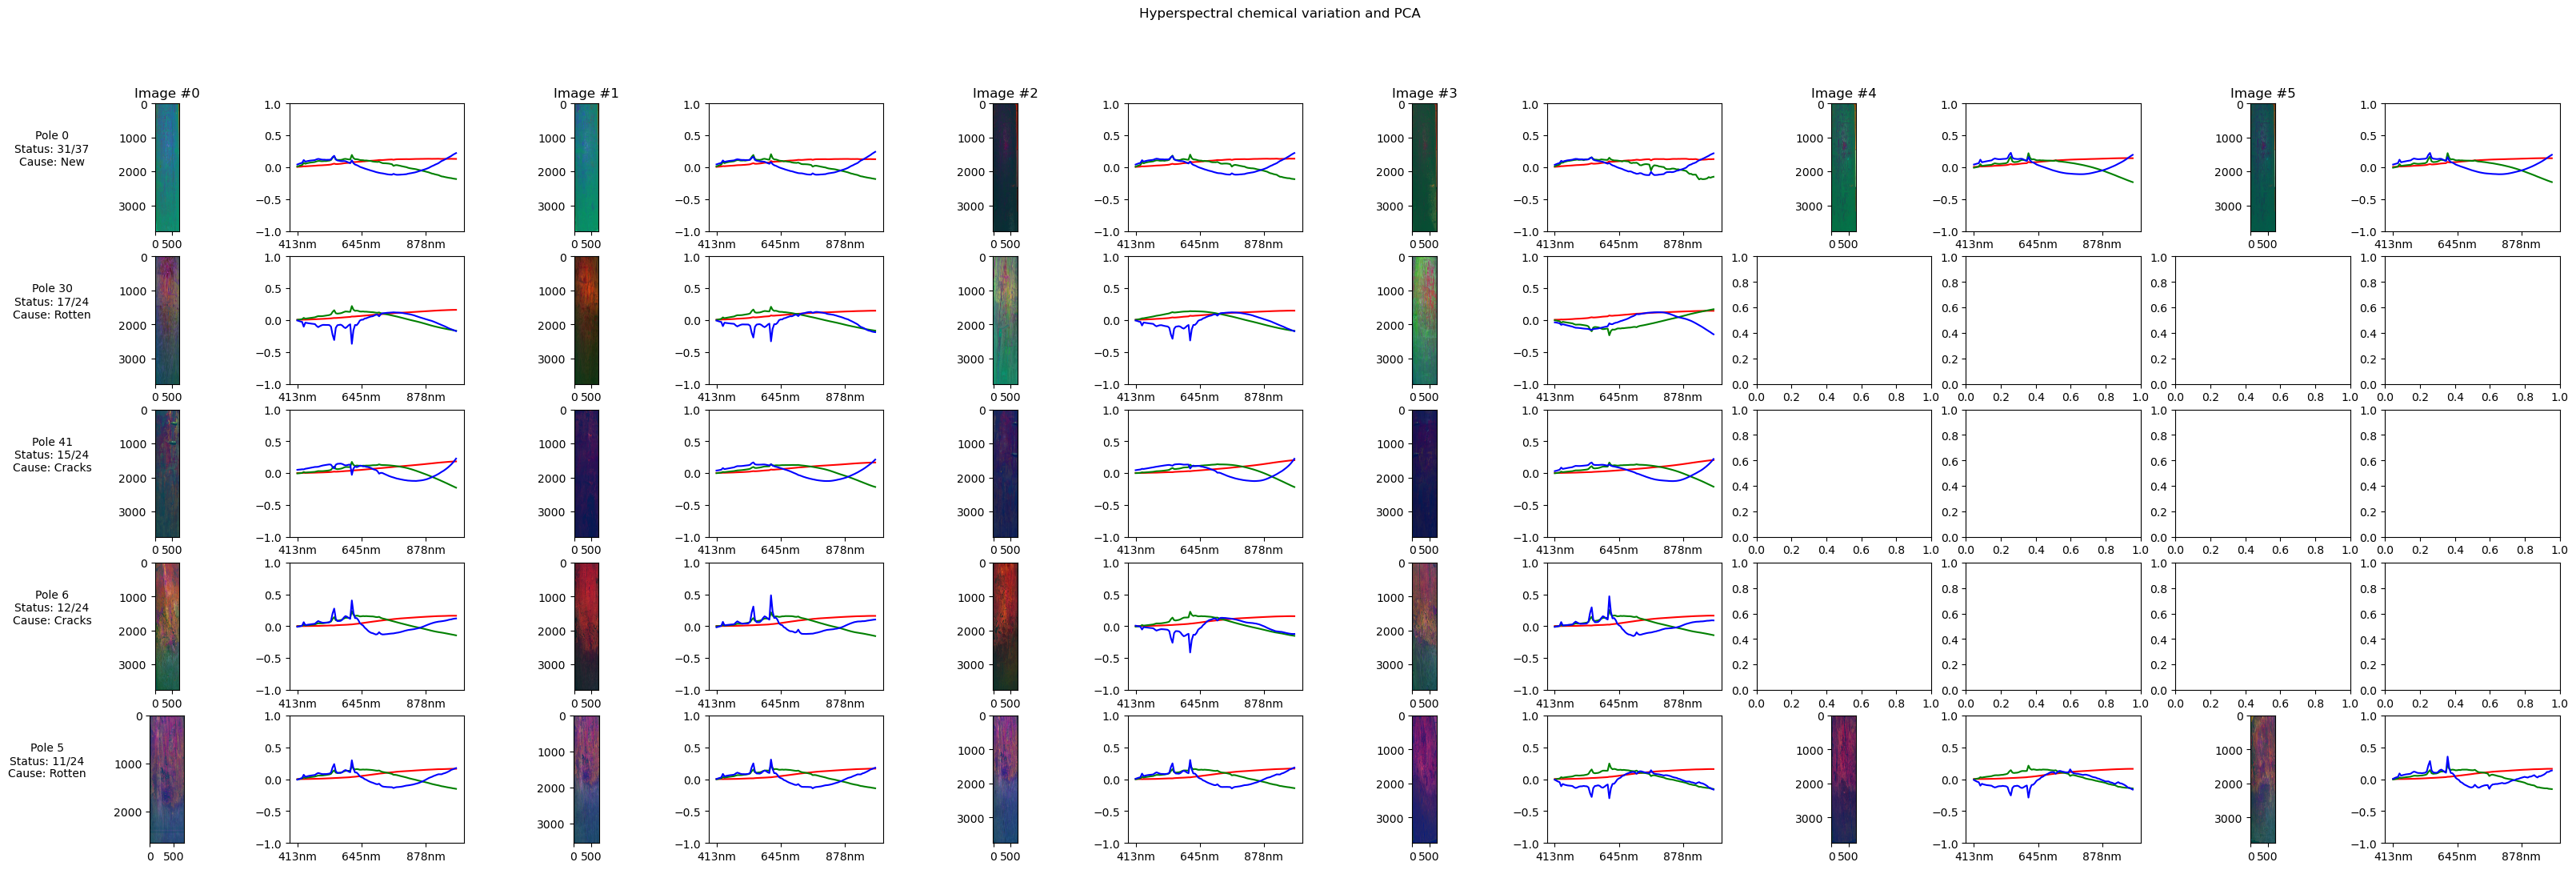

In [16]:
view_hyperspectral_chemical()